# **Predicting Pneumonia with MONAI and DenseNet264**

Code adapted by Cole Richardson for UVM course BME5990 Deep Learning.

MONAI code originally created by rijobro github.

MedMNIST code and data from MedMNIST github and medmnist.com



---





# Notebook Format

1. Install libraries and import packages
2. Load and clean pneumonia chest x-ray data from MedMNIST
3. Creating model and data loaders
4. Training and validation of the model
5. Plot the results of the training loss and validation accuracy throughout each epoch
6. Plot some example predictions
5. Confusion Matrix
6. Plot saliency examples






---


# 1. Install Libraries and import packages

In [ ]:
# Install libraries for models, data, and saliency
!pip install monai
!pip install medmnist
!pip install captum

# Import torch packages and other common packages
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision import models, transforms
from tqdm import tqdm, trange

# Import monai packages
from monai.networks.blocks import MLPBlock
from monai.networks.nets import DenseNet
import monai
from monai.apps import download_and_extract
from monai.data import CacheDataset, DataLoader, pad_list_data_collate, partition_dataset
from monai.networks import eval_mode
import monai.transforms as mt
from monai.utils import set_determinism

# Imports for confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Importing Saliency
from captum.attr import Saliency

# Use GPU if possible, else CPU (not recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=240f1a22563eba05af596e2bc6bad96826be73fb41ea4279bb34739d439adf21
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.9 MB/s eta 0:00:00


# 2. Load and clean pneumonia data chest x-rays from MedMNIST

In [ ]:
# Load PneumoniaMNIST dataset from MedMNIST
from medmnist import PneumoniaMNIST
def get_pneumonia_mnist_data(split, transform=None):
  return PneumoniaMNIST(split=split, transform=transform, download=True)

# Setting up transformer for the PneumoniaMNIST images
transform = transforms.Compose([
    transforms.Resize(250), # tried resizing to 256 and 300 however lost quality
    transforms.CenterCrop(224),   # dense net works best with 224 however images lose quality while printing
    transforms.ToTensor(),  # convert the images to a PyTorch tensor (values scaled to [0,1])
    transforms.Normalize((0.5,), (0.5,))  # Normalize with single-channel parameters
])

# Load train and validation splits from data
train_data = get_pneumonia_mnist_data(split='train', transform=transform)
val_data = get_pneumonia_mnist_data(split='val', transform=transform)

100%|██████████| 4.17M/4.17M [00:02<00:00, 1.72MB/s]

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


# 3. Creating model and data loaders

In [ ]:
# Preparing for the model
batch_size = 32  # defining batch size

# Create dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Load pretrained DenseNet264 model from MONAI
model = monai.networks.nets.DenseNet264(
    spatial_dims=2,          # 2D input images
    in_channels=1,           # 1 input channels for PneumoniaMNIST (greyscale)
    out_channels=2           # 2 output classes for classification
)

In [ ]:
# Move the model to the GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet264(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchN

# 4. Training and validation of the model

In [ ]:
# Use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
# CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

In [ ]:
# Set number of epochs to run
num_epochs = 100
# Create empty lists to store training and validation accuracy
train_acc = []
val_acc = []
epoch_loss_values = []

# Create loop for training and validation phases
for epoch in range(num_epochs):
    # Training phase
    model.train()   # set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:  # assume train_loader is defined
        inputs, labels = inputs.to(device), labels.squeeze().to(device)

        optimizer.zero_grad()  # zero the gradients before each backward pass
        outputs = model(inputs)  # forward pass
        loss = loss_function(outputs, labels)  # compute the loss
        loss.backward()  # backpropagation
        optimizer.step()  # update the model parameters

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # get the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total
    train_acc.append(accuracy)

    # Calculate and save loss
    epoch_loss = running_loss / len(train_loader)  # Calculate average loss for the epoch
    epoch_loss_values.append(epoch_loss) # Store the epoch loss

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")



    # Validation phase
    model.eval()  # set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # no gradients are needed for validation
        for inputs, labels in val_loader:  # assuming val_loader is defined
            inputs, labels = inputs.to(device), labels.squeeze().to(device)
            outputs = model(inputs)  # forward pass

            _, predicted = torch.max(outputs, 1)  # get the predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation accuracy
    val_accuracy = 100 * correct / total  # calculate accuracy
    val_acc.append(val_accuracy)

    # Print all results
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/100, Loss: 0.2254, Accuracy: 91.29%
Epoch 1/100, Validation Accuracy: 91.22%
Epoch 2/100, Loss: 0.1472, Accuracy: 94.33%
Epoch 2/100, Validation Accuracy: 93.13%
Epoch 3/100, Loss: 0.1413, Accuracy: 94.50%
Epoch 3/100, Validation Accuracy: 87.79%
Epoch 4/100, Loss: 0.1443, Accuracy: 94.22%
Epoch 4/100, Validation Accuracy: 93.89%
Epoch 5/100, Loss: 0.1269, Accuracy: 95.31%
Epoch 5/100, Validation Accuracy: 88.93%
Epoch 6/100, Loss: 0.1494, Accuracy: 93.95%
Epoch 6/100, Validation Accuracy: 94.27%
Epoch 7/100, Loss: 0.1085, Accuracy: 95.48%
Epoch 7/100, Validation Accuracy: 92.56%
Epoch 8/100, Loss: 0.1116, Accuracy: 95.54%
Epoch 8/100, Validation Accuracy: 95.42%
Epoch 9/100, Loss: 0.1030, Accuracy: 96.24%
Epoch 9/100, Validation Accuracy: 96.56%
Epoch 10/100, Loss: 0.1100, Accuracy: 95.77%
Epoch 10/100, Validation Accuracy: 94.85%
Epoch 11/100, Loss: 0.1024, Accuracy: 96.01%
Epoch 11/100, Validation Accuracy: 96.76%
Epoch 12/100, Loss: 0.0913, Accuracy: 96.64%
Epoch 12/100, Va

# 5. Plot the results of the training loss and validation accuracy throughout each epoch

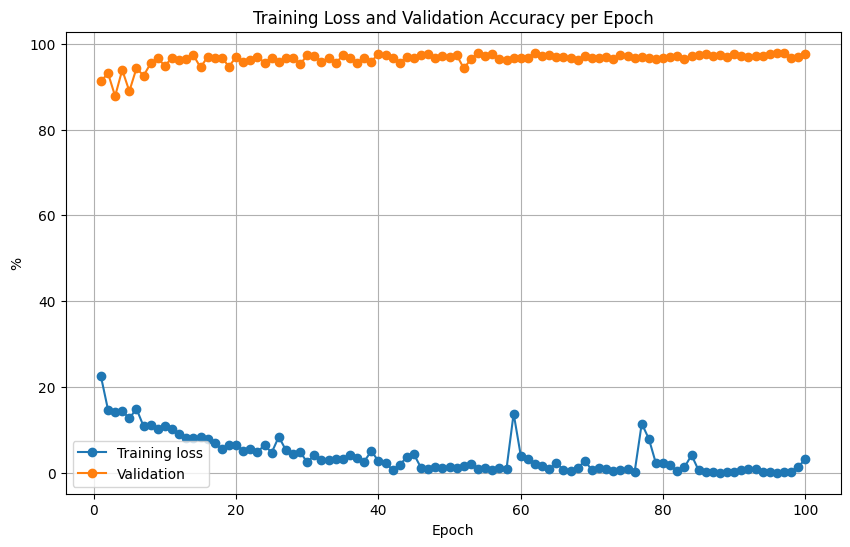

In [ ]:
# Plot Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), [loss * 100 for loss in epoch_loss_values], marker='o', label='Training loss')
# Plot Validation Accuracy
plt.plot(range(1, num_epochs + 1), val_acc, marker='o', label='Validation')
# Set labels and titles
plt.xlabel("Epoch")
plt.ylabel("%")
plt.title("Training Loss and Validation Accuracy per Epoch")
plt.grid()
plt.legend()
plt.show()

# 6. Plot some example predictions

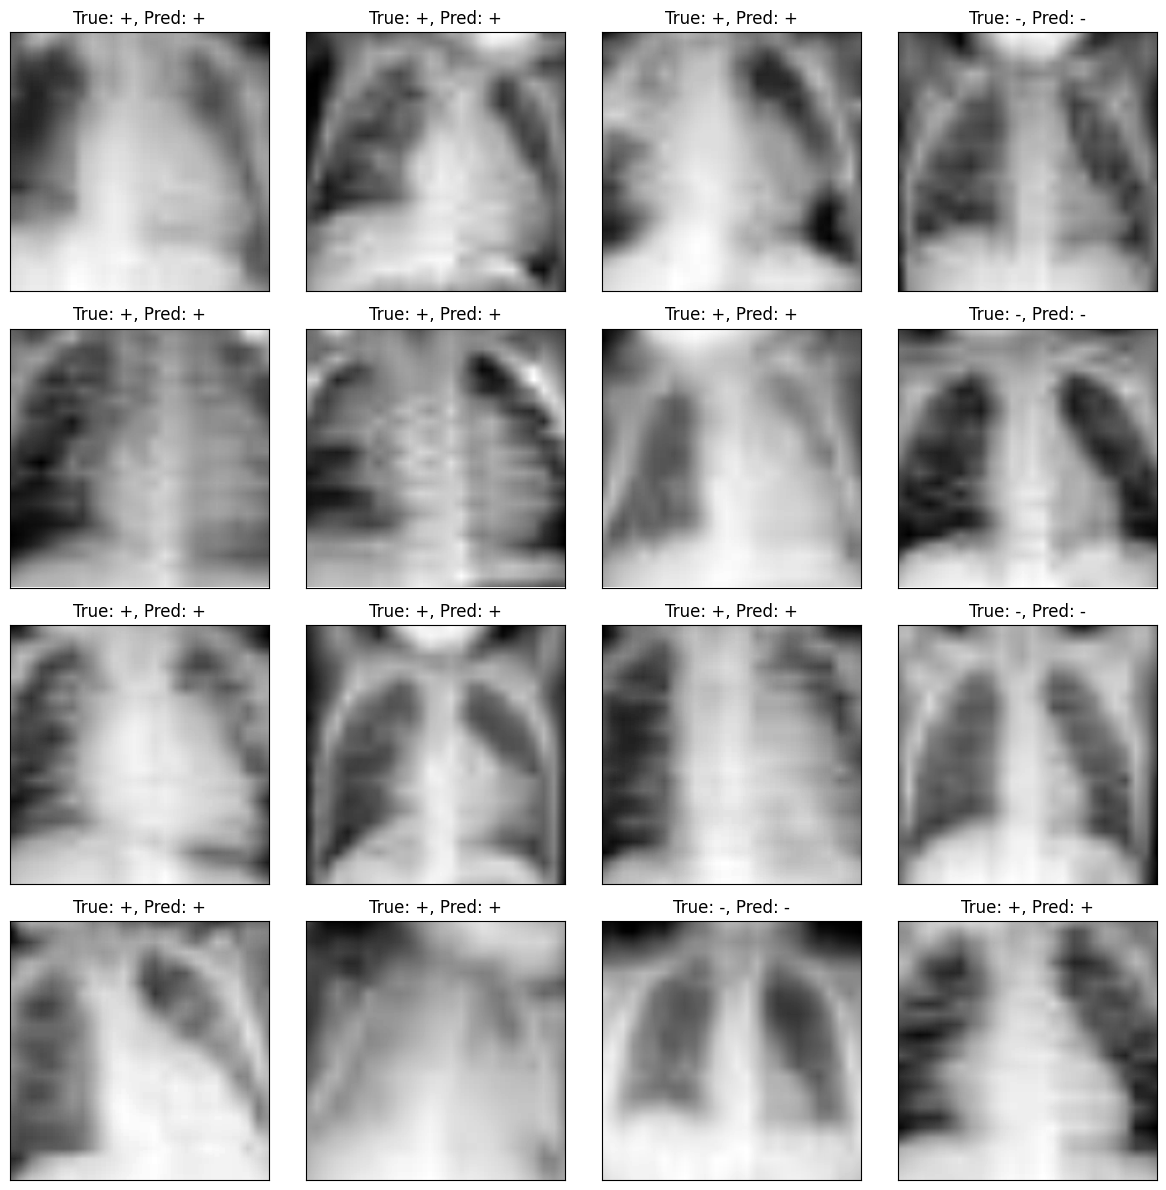

In [ ]:
# Get a batch of images and labels from the validation loader
images, labels = next(iter(val_loader))

# Move images and labels to the device (GPU if available)
images = images.to(device)
labels = labels.to(device)

# Make predictions with the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Plot the images and predictions
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    # Display the image
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')  # Assuming grayscale images

    # Set the title with the true and predicted labels
    true_label = "+" if labels[i].cpu().item() ==1 else "-"
    pred_label = "+" if predicted[i].cpu().item() ==1 else "-"
    ax.set_title(f"True: {true_label}, Pred: {pred_label}")

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.show()

# 7. Confusion matrix

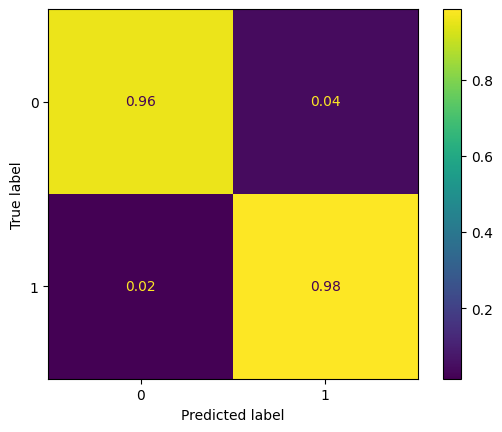

In [ ]:
# Initialize the confusion matrix
all_preds = []
all_labels = []

# Set the model to evaluation mode
model.eval()

# Loop over the validation data loader
with torch.no_grad():  # No need to calculate gradients during inference
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.squeeze().to(device)

        # Forward pass to get predictions
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append predictions and labels to lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix to get decimal percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(values_format='.2f')  # Format values as decimal percentages with 2 decimal places

# 8. Plot saliency examples

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


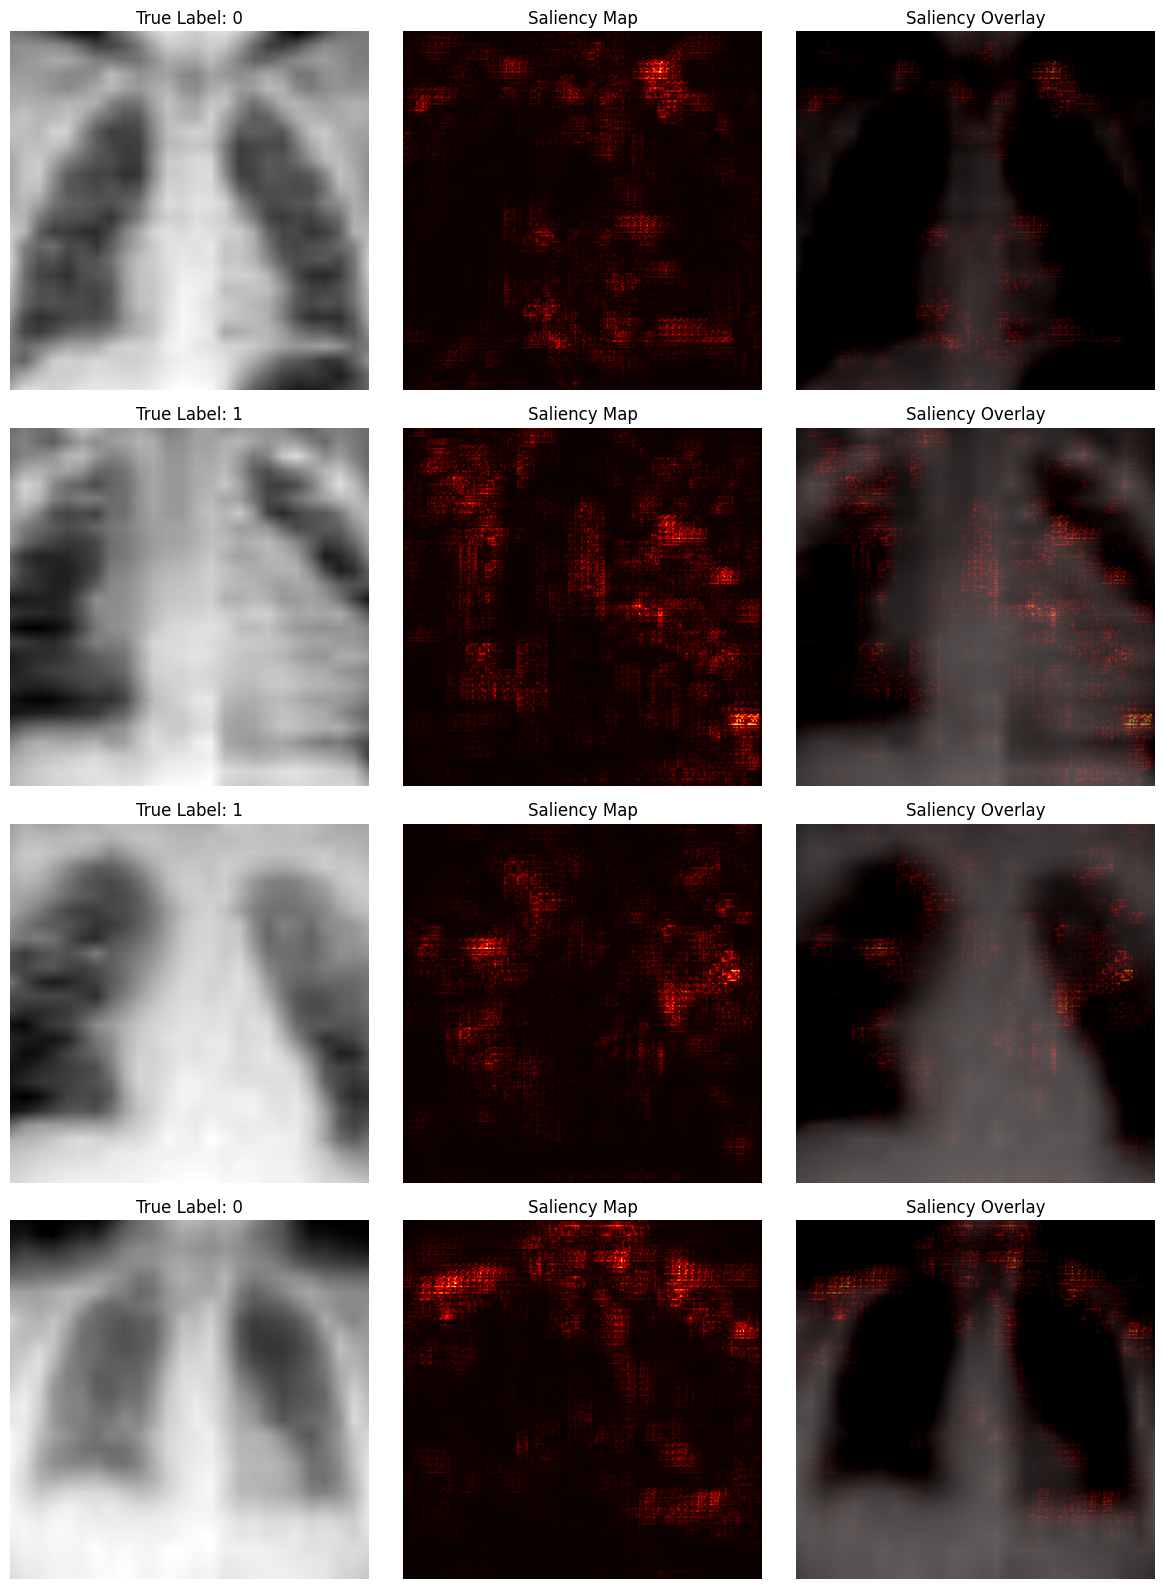

In [ ]:
# Function to compute and plot saliency maps
def plot_saliency_maps(model, images, labels, num_examples=4):

    # Initialize Saliency method
    saliency = Saliency(model)

    # Select a subset of images and labels for plotting
    selected_indices = torch.randperm(images.shape[0])[:num_examples]
    selected_images = images[selected_indices]
    selected_labels = labels[selected_indices]

    # Calculate saliency maps
    attributions = saliency.attribute(selected_images.to(device), target=selected_labels.squeeze().to(device))

    # Plot the images and their corresponding saliency maps
    fig, axes = plt.subplots(nrows=num_examples, ncols=3, figsize=(12, 4 * num_examples))

    for i, ax in enumerate(axes):
        # Display the original image
        ax[0].imshow(selected_images[i].cpu().squeeze(), cmap='gray')
        ax[0].set_title(f"True Label: {selected_labels[i].cpu().item()}")
        ax[0].axis('off')

        # Display the saliency map
        ax[1].imshow(attributions[i].cpu().squeeze(), cmap='hot')
        ax[1].set_title("Saliency Map")
        ax[1].axis('off')

        # Overlay saliency map on original image
        original_image = selected_images[i].cpu().squeeze().numpy()
        saliency_map = attributions[i].cpu().squeeze().numpy()

        # Normalize saliency map to 0-1 range for color mapping
        saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

        # Apply colormap and blend with original image
        colored_saliency_map = plt.cm.hot(saliency_map)  # Use 'hot' colormap
        overlay = (0.5 * original_image[:, :, None] + 0.5 * colored_saliency_map[:, :, :3])

        ax[2].imshow(overlay)
        ax[2].set_title("Saliency Overlay")
        ax[2].axis('off')

    plt.tight_layout()
    plt.show()

# Get a batch of images and labels from the validation loader
images, labels = next(iter(val_loader))

# Plot saliency maps for the selected examples
plot_saliency_maps(model, images, labels)